In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab import drive
from keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D, Embedding, BatchNormalization, Bidirectional
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model

# Data

In [2]:
drive.mount('/content/drive')

X_train_textual = pd.read_csv('/content/drive/My Drive/thesis/data/processed_data/textual/X_train.csv')

X_train = np.genfromtxt('/content/drive/My Drive/thesis/data/processed_data/tokenized/X_train.csv', delimiter=',')
X_val =  np.genfromtxt('/content/drive/My Drive/thesis/data/processed_data/tokenized/X_val.csv', delimiter=',')
X_test =  np.genfromtxt('/content/drive/My Drive/thesis/data/processed_data/tokenized/X_test.csv', delimiter=',')

Y_train = np.genfromtxt('/content/drive/My Drive/thesis/data/processed_data/tokenized/Y_train.csv', delimiter=',')
Y_val = np.genfromtxt('/content/drive/My Drive/thesis/data/processed_data/tokenized/Y_val.csv', delimiter=',')
Y_test = np.genfromtxt('/content/drive/My Drive/thesis/data/processed_data/tokenized/Y_test.csv', delimiter=',')

print(X_train_textual.shape)
print(X_train.shape,Y_train.shape)
print(X_val.shape,Y_val.shape)
print(X_test.shape,Y_test.shape)

Mounted at /content/drive
(291, 1)
(291, 47) (291, 3)
(98, 47) (98, 3)
(130, 47) (130, 3)


In [3]:
from sklearn.utils import class_weight
labels =  [np.where(r==1)[0][0] for r in Y_train]

labels_dict  = {'negative' : labels.count(0),
                'neutral': labels.count(1),
                'positive': labels.count(2)}

class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(labels),
                                        y = labels                                                 
                                    )
class_weights = dict(zip(np.unique(labels), class_weights))

# Load and Setup Glove

In [4]:
def read_glove_vector(glove_vec):
  with open(glove_vec, 'r', encoding='UTF-8') as f:
    words = set()
    word_to_vec_map = {}
    for line in f:
      w_line = line.split()
      curr_word = w_line[0]
      word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)
  return word_to_vec_map

word_to_vec_map = read_glove_vector('/content/drive/My Drive/thesis/data/vectors.txt')
vocab_len_list = [len(x) for x in word_to_vec_map.values()]

vocab_len = vocab_len_list[0]
num_vocab = len(vocab_len_list)

In [16]:
def draw_confusion_matrix(y_predict):
  "gets the one-hot-encoded y_predict and draw confusion matrix for y_test and y_predict"
  y_pred = [np.where(r==1)[0][0] for r in y_predict]
  y_test = [np.where(r==1)[0][0] for r in Y_test]

  confusion = confusion_matrix(y_test, y_pred)
  # print('Confusion Matrix\n')
  # print(confusion)

  ax = sns.heatmap(confusion/np.sum(confusion), annot=True, cmap='Blues')
  ax.set_xlabel('\nPredicted sentiment Category')
  ax.set_ylabel('Actual senntiment Category ');
  ax.xaxis.set_ticklabels(['negative','neutral', 'positive'])
  ax.yaxis.set_ticklabels(['negative','neutral', 'positive'])

  plt.show()

In [5]:
vocal_per_sentc = [len(x) for x in X_train_textual.features.values]

tokenizer = Tokenizer(num_words=max(vocal_per_sentc))
tokenizer.fit_on_texts(X_train_textual.features)

words_to_index = tokenizer.word_index

In [6]:
vocab_len = len(words_to_index) + 1 
embed_vector_len = word_to_vec_map['درس'].shape[0]

emb_matrix = np.zeros((vocab_len, embed_vector_len))
print(emb_matrix.shape)

(801, 50)


In [7]:
for word, index in words_to_index.items():
  embedding_vector = word_to_vec_map.get(word)
  if embedding_vector is not None:
    emb_matrix[index, :] = embedding_vector

In [8]:
embed_vector_len

50

In [9]:
embedding_layer = Embedding(input_dim=vocab_len, output_dim=embed_vector_len, input_length=X_train.shape[1], weights = [emb_matrix], trainable=False)

# Methods 

In [10]:
from gc import callbacks

checkpoint_path = "/content/drive/My Drive/thesis/code/saved_glove_model/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

def fit_classifier_with_weight(classifier,epochs, batch_size,monitor = 'val_loss', verbose = 'auto'):
  history = classifier.fit(
    x = X_train, 
    y = Y_train, 
    epochs=epochs, 
    batch_size=batch_size,
    validation_data=(X_val, Y_val),
    verbose = verbose,
    class_weight=class_weights, 
    # callbacks=[EarlyStopping(patience=10, min_delta=0.001, restore_best_weights=True,monitor = monitor)]
    callbacks=[ModelCheckpoint(filepath=checkpoint_path, 
                               monitor=monitor,
                               mode='max',
                               save_best_only=True)]
    )
  return history

def evaluate_classifier(classifier):
  accr = classifier.evaluate(X_test,Y_test)
  print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))
  return accr

def plot_categorical_crossentropy(history):
  plt.title('Loss')
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='test')
  plt.legend()
  plt.show()

  plt.title('categorical_accuracy')
  plt.plot(history.history['categorical_accuracy'], label='train')
  plt.plot(history.history['val_categorical_accuracy'], label='test')
  plt.legend()
  plt.show()

# Model

In [11]:
classifier = Sequential()
classifier.add(embedding_layer)
classifier.add(Dropout(0.4))
classifier.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
classifier.add(Dropout(0.4))
classifier.add(Dense(32))
classifier.add(Dropout(0.4))
classifier.add(Dense(3, activation='softmax', bias_initializer=tf.keras.initializers.VarianceScaling(scale=0.1, mode='fan_in', distribution='uniform'))) 
classifier.compile(loss='binary_crossentropy', optimizer='adam', metrics=[metrics.categorical_accuracy])  
print(classifier.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 47, 50)            40050     
                                                                 
 dropout (Dropout)           (None, 47, 50)            0         
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 9

# Fit on train data

Epoch 1/50
3/3 [==============================] - 12s 4s/step - loss: 0.7870 - categorical_accuracy: 0.3505 - val_loss: 0.6893 - val_categorical_accuracy: 0.4592
Epoch 2/50
3/3 [==============================] - 5s 2s/step - loss: 0.7001 - categorical_accuracy: 0.3711 - val_loss: 0.6335 - val_categorical_accuracy: 0.4694
Epoch 3/50
3/3 [==============================] - 5s 2s/step - loss: 0.6897 - categorical_accuracy: 0.3505 - val_loss: 0.6184 - val_categorical_accuracy: 0.5204
Epoch 4/50
3/3 [==============================] - 0s 116ms/step - loss: 0.6546 - categorical_accuracy: 0.4021 - val_loss: 0.6164 - val_categorical_accuracy: 0.5204
Epoch 5/50
3/3 [==============================] - 0s 130ms/step - loss: 0.6523 - categorical_accuracy: 0.4089 - val_loss: 0.6157 - val_categorical_accuracy: 0.5204
Epoch 6/50
3/3 [==============================] - 0s 117ms/step - loss: 0.6516 - categorical_accuracy: 0.3746 - val_loss: 0.6191 - val_categorical_accuracy: 0.4082
Epoch 7/50
3/3 [========

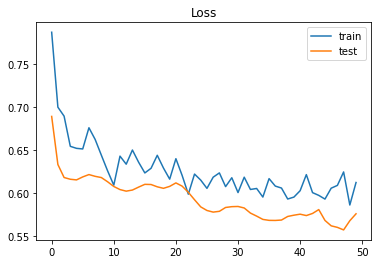

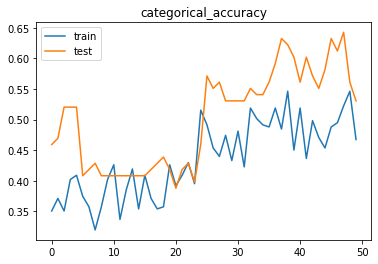

In [12]:
epochs = 50
batch_size = 128
history = fit_classifier_with_weight(classifier, epochs, batch_size, 'val_categorical_accuracy')
plot_categorical_crossentropy(history)

# load best model 

In [13]:
print("best train accuracy : " , history.history['categorical_accuracy'][np.argmax(history.history['categorical_accuracy'])], "in epoch : ",np.argmax(history.history['categorical_accuracy']))
print("best validation accuracy : " , history.history['val_categorical_accuracy'][np.argmax(history.history['val_categorical_accuracy'])], "in epoch : ",np.argmax(history.history['val_categorical_accuracy']))

best train accuracy :  0.5463917255401611 in epoch :  38
best validation accuracy :  0.6428571343421936 in epoch :  47


In [14]:
best_cassifier = load_model(checkpoint_path)

# evaluate on test data

In [15]:
evaluate_classifier(best_cassifier)

5/5 [==============================] - 0s 12ms/step - loss: 0.5631 - categorical_accuracy: 0.6000
Test set
  Loss: 0.563
  Accuracy: 0.600


[0.563126266002655, 0.6000000238418579]

5/5 [==============================] - 0s 9ms/step


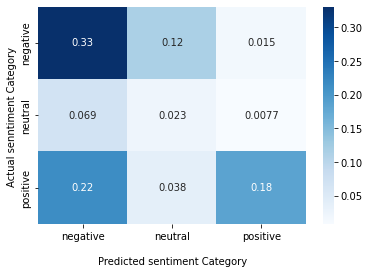

In [17]:
Y_predict = classifier.predict(X_test)
Y_predict = to_categorical(np.argmax(Y_predict, axis=1), 3)
draw_confusion_matrix(Y_predict)